In [14]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

## 파일 불러오기

In [2]:
voc_paths = {
    "voc2": "/home/gracejang42/CP/final_data/voc2/long_df.csv",
    "voc3": "/home/gracejang42/CP/final_data/voc3/long_df.csv",
    "voc4": "/home/gracejang42/CP/final_data/voc4/long_df.csv",
    "voc5": "/home/gracejang42/CP/final_data/voc5/long_df.csv",
    "voc7": "/home/gracejang42/CP/final_data/voc7/long_df.csv",
    "voc8": "/home/gracejang42/CP/final_data/voc8/long_df.csv",
    "voc9": "/home/gracejang42/CP/final_data/voc9/long_df.csv",
    "voc10": "/home/gracejang42/CP/final_data/voc10/long_df.csv",
}

In [3]:
dfs = []
for name, path in voc_paths.items():
    print(f"📂 Loading: {name} → {path}")
    df = pd.read_csv(path)
    df["sample_key"] = name + "_" + df["sample_id"].astype(str)
    df["label_name"] = name
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

print("\n🔍 merged shape:", df_all.shape)

📂 Loading: voc2 → /home/gracejang42/CP/final_data/voc2/long_df.csv
📂 Loading: voc3 → /home/gracejang42/CP/final_data/voc3/long_df.csv
📂 Loading: voc4 → /home/gracejang42/CP/final_data/voc4/long_df.csv
📂 Loading: voc5 → /home/gracejang42/CP/final_data/voc5/long_df.csv
📂 Loading: voc7 → /home/gracejang42/CP/final_data/voc7/long_df.csv
📂 Loading: voc8 → /home/gracejang42/CP/final_data/voc8/long_df.csv
📂 Loading: voc9 → /home/gracejang42/CP/final_data/voc9/long_df.csv
📂 Loading: voc10 → /home/gracejang42/CP/final_data/voc10/long_df.csv

🔍 merged shape: (576000, 6)


In [4]:
df_all

,sample_id,time_index,sensor,intensity,sample_key,label_name
0,1,0,pos1_Sensor2,542.419136,voc2_1,voc2
1,1,0,pos1_Sensor1,163.974254,voc2_1,voc2
2,1,0,pos1_Sensor11,823.123927,voc2_1,voc2
3,1,0,pos1_Sensor12,615.730435,voc2_1,voc2
4,1,0,pos2_Sensor4,472.492491,voc2_1,voc2
...,...,...,...,...,...,...
575995,10,199,pos8_Sensor34,151.336330,voc10_10,voc10
575996,10,199,pos9_Sensor30,270.724714,voc10_10,voc10
575997,10,199,pos9_Sensor29,567.987076,voc10_10,voc10
575998,10,199,pos9_Sensor31,1014.048324,voc10_10,voc10


## 센서별 I0 구하기

In [7]:
BASELINE_END = 50  # I0 계산 구간

feature_rows = []

for (sample_key, sensor), g in df_all.groupby(["sample_key", "sensor"]):
    baseline = g[g["time_index"] < BASELINE_END]

    if len(baseline) == 0:
        I0 = np.nan
    else:
        I0 = baseline["intensity"].mean()

    label = g["label_name"].iloc[0]

    feature_rows.append({
        "sample_key": sample_key,
        "sensor": sensor,
        "I0": I0,
        "label_name": label
    })

df_feat = pd.DataFrame(feature_rows)
df_feat

,sample_key,sensor,I0,label_name
0,voc10_1,pos1_Sensor1,113.209559,voc10
1,voc10_1,pos1_Sensor11,611.169285,voc10
2,voc10_1,pos1_Sensor12,461.715718,voc10
3,voc10_1,pos1_Sensor2,385.943944,voc10
4,voc10_1,pos2_Sensor10,400.253174,voc10
...,...,...,...,...
2875,voc9_9,pos8_Sensor34,164.420434,voc9
2876,voc9_9,pos9_Sensor29,574.392518,voc9
2877,voc9_9,pos9_Sensor30,277.734523,voc9
2878,voc9_9,pos9_Sensor31,1016.021531,voc9


In [9]:
# pivot → sample x sensor_I0 matrix
df_wide = df_feat.pivot_table(index="sample_key", columns="sensor", values="I0")

# 라벨 붙이기
labels = df_feat.groupby("sample_key")["label_name"].first()
df_wide["label_name"] = labels

print("\n📏 Feature matrix shape:", df_wide.shape)

df_filtered = df_wide


📏 Feature matrix shape: (80, 37)


In [10]:
# feature / label 분리
X = df_filtered.drop(columns=["label_name"]).values.astype(float)
y_str = df_filtered["label_name"].values

# 라벨 인코딩
le = LabelEncoder()
y = le.fit_transform(y_str)
class_names = list(le.classes_)

print("\n🎯 Class mapping:", {i: c for i, c in enumerate(class_names)})
print("X shape:", X.shape)


🎯 Class mapping: {0: 'voc10', 1: 'voc2', 2: 'voc3', 3: 'voc4', 4: 'voc5', 5: 'voc7', 6: 'voc8', 7: 'voc9'}
X shape: (80, 36)


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

svm_model = SVC(kernel="rbf", C=10, gamma="scale", random_state=42)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(svm_model, X_scaled, y, cv=skf)

print(f"\n🔥 SVM Accuracy (I0 only) = {scores.mean():.4f} ± {scores.std():.4f}")
print("Fold scores:", scores)


🔥 SVM Accuracy (I0 only) = 0.9250 ± 0.0829
Fold scores: [0.875 0.75  1.    1.    1.    0.875 0.875 1.    0.875 1.   ]



===== Classification Report =====
              precision    recall  f1-score   support

       voc10       1.00      0.80      0.89        10
        voc2       1.00      0.90      0.95        10
        voc3       0.83      1.00      0.91        10
        voc4       0.90      0.90      0.90        10
        voc5       1.00      0.90      0.95        10
        voc7       0.91      1.00      0.95        10
        voc8       1.00      0.90      0.95        10
        voc9       0.83      1.00      0.91        10

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.93        80
weighted avg       0.93      0.93      0.93        80



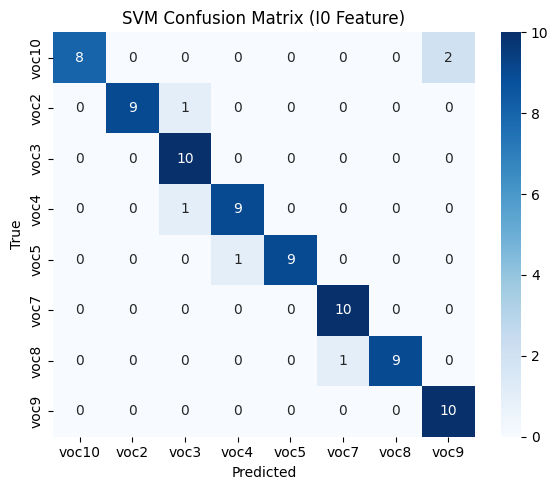

In [13]:
y_pred = cross_val_predict(svm_model, X_scaled, y, cv=skf)

print("\n===== Classification Report =====")
print(classification_report(y, y_pred, target_names=class_names))

cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=class_names, yticklabels=class_names
)
plt.title("SVM Confusion Matrix (I0 Feature)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## RF

In [15]:
X = df_filtered.drop(columns=["label_name"]).values.astype(float)
y_str = df_filtered["label_name"].values

In [16]:
# RF는 scaling 없어도 됨 (원하면 X_scaled 대신 X 사용)
X_input = np.nan_to_num(X, nan=0.0)  # I0에 NaN이 있으면 0으로 처리 (필요하면 다른 방식 가능)

rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"  # 클래스 불균형 있으면 도움
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(rf_model, X_input, y, cv=skf, scoring="accuracy")
print(f"\n🔥 RF Accuracy (I0 only) = {scores.mean():.4f} ± {scores.std():.4f}")
print("Fold scores:", scores)


🔥 RF Accuracy (I0 only) = 0.8875 ± 0.1038
Fold scores: [0.625 0.875 0.875 1.    1.    0.875 0.875 1.    0.875 0.875]


In [18]:
y_pred = cross_val_predict(rf_model, X_input, y, cv=skf)

print("\n===== Classification Report (Random Forest) =====")
print(classification_report(y, y_pred, target_names=class_names))


===== Classification Report (Random Forest) =====
              precision    recall  f1-score   support

       voc10       0.89      0.80      0.84        10
        voc2       0.82      0.90      0.86        10
        voc3       0.89      0.80      0.84        10
        voc4       1.00      0.90      0.95        10
        voc5       0.91      1.00      0.95        10
        voc7       0.91      1.00      0.95        10
        voc8       0.90      0.90      0.90        10
        voc9       0.80      0.80      0.80        10

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80



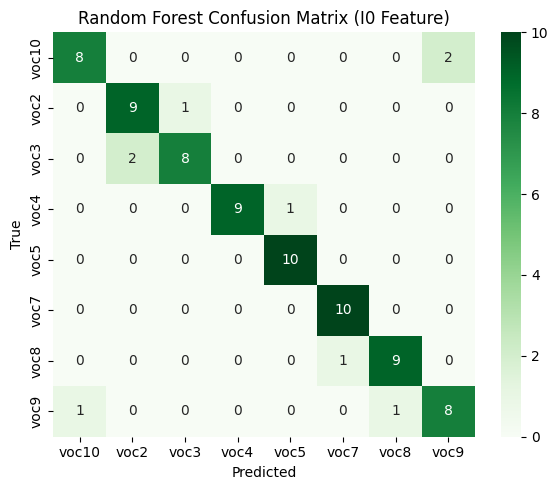

In [20]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Greens",
    xticklabels=class_names, yticklabels=class_names
)
plt.title("Random Forest Confusion Matrix (I0 Feature)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()